**注意，这里的m不支持随机**

In [3]:
import networkx as nx
import torch
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU
import sys
from dgl.nn import GraphConv#instead of GCNConv in PyG
import dgl
sys.path.append('..')
from model.models_dgl import GraphConvWL
from ba4label_dgl_total import *
from torch import nn
def generate_single_sample(label, perturb_type, nodes_num = 25, m = 1, perturb_dic = {}, 
seed = None):
    '''
    return a networkx instance
    '''
    basis_type = "ba"
    which_type = label
    if which_type == 0:
        if perturb_type == 0:
            G, role_id, plug_id = build_graph(nodes_num, basis_type, [], start = 0, m = m, seed = seed)
        else:
            G, role_id, plug_id = build_graph(nodes_num - perturb_type, basis_type, [[perturb_dic[perturb_type]]], start = 0, m = m, seed = seed)
    else:
        list_shapes = [["house"]] * (which_type - 1) + [["five_cycle"]] * (3 - which_type)
        if perturb_type != 0:
            list_shapes = list_shapes + [[perturb_dic[perturb_type]]]
        G, role_id, plug_id = build_graph(nodes_num-10-perturb_type, basis_type, list_shapes, start = 0, m = m, seed = seed)
    return G

class FixedNet(nn.Module):
    def __init__(self, num_node_features, num_classes, num_layers, concat_features, conv_type):
        super(FixedNet, self).__init__()
        dim = 1
        self.convs = torch.nn.ModuleList()
        if conv_type == 'GraphConvWL':#'GCNConv':
            conv_class = GraphConvWL
            #kwargs = {'add_self_loops': False}
        elif conv_type == 'GraphConv':
            conv_class = GraphConv
            kwargs = {}
        else:
            raise RuntimeError(f"conv_type {conv_type} not supported")

        self.convs.append(conv_class(num_node_features, dim, bias = False))#, **kwargs))
        for i in range(num_layers - 1):
            self.convs.append(conv_class(dim, dim, bias = False))#, **kwargs))
        self.concat_features = concat_features


    def forward(self, g, x):
        '''
        g: DGL Graph
        x: node feature
        '''
        xs = [x]
        for conv in self.convs:
            x = conv(g, x)
            x = F.relu(x)
            xs.append(x)
        if self.concat_features:
            x = torch.cat(xs, dim=1)
        g.ndata['h'] = x
        hg = dgl.mean_nodes(g, 'h')
        return hg, xs

Using backend: pytorch


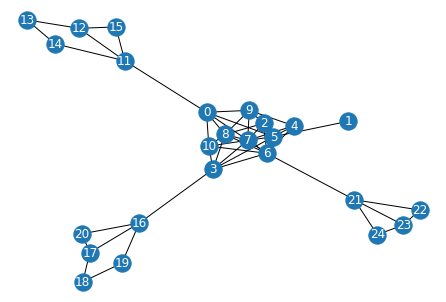

In [4]:
nodes_num = 25
G = generate_single_sample(3, 4, nodes_num, m = 5, perturb_dic = {4:'square_diagonal'}, seed = 0)
pos = nx.spring_layout(G, seed = 0)
nx.draw(G, pos, with_labels = True, font_color = 'white')

In [6]:
model1 = FixedNet(1, 4, 1, True, 'GraphConvWL')
model2 = FixedNet(1, 4, 2, True, 'GraphConvWL')
model3 = FixedNet(1, 4, 3, True, 'GraphConvWL')
model4 = FixedNet(1, 4, 4, True, 'GraphConvWL')
for i in range(1, 5):
    for p in eval('model'+str(i)).parameters():
        torch.nn.init.constant_(p, 1)

In [7]:
output1, h1 = model1(dgl.from_networkx(G), torch.ones((nodes_num,1)))
print(h1[1])

tensor([[5.],
        [3.],
        [5.],
        [3.],
        [3.],
        [3.],
        [3.],
        [2.],
        [3.],
        [2.],
        [2.],
        [5.],
        [4.],
        [3.],
        [3.],
        [3.],
        [5.],
        [4.],
        [3.],
        [3.],
        [3.],
        [5.],
        [3.],
        [4.],
        [3.]], grad_fn=<ReluBackward0>)


# 多生成一些图，看一下分布

In [8]:
import pandas as pd
from collections import defaultdict
model1_distribution = pd.DataFrame(columns=['label','x','h1'])
Dataset_with_perturb = defaultdict(list)
Dataset_without_perturb = defaultdict(list)
for label in range(4):
    for _ in range(10000):
        Dataset_with_perturb[label].append(generate_single_sample(3, 4, nodes_num, perturb_dic = {4:'square_diagonal'}))
        Dataset_without_perturb[label].append(generate_single_sample(3, 0, nodes_num))

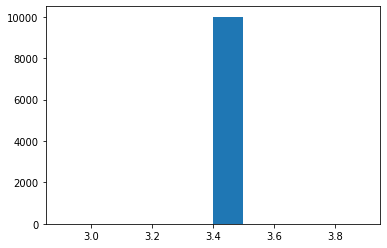

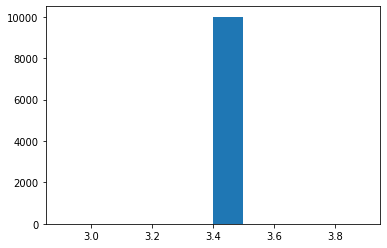

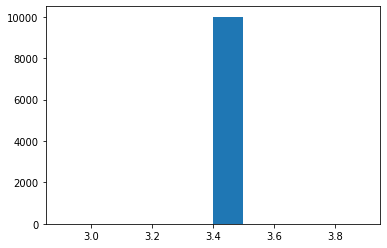

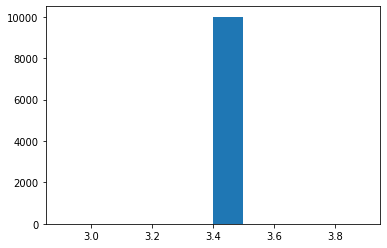

In [9]:
import matplotlib.pyplot as plt
for label in range(4):
    model1_distribution = pd.DataFrame(columns=['label','x','h1'])
    for G in Dataset_with_perturb[label]:
        output1, h1 = model1(dgl.from_networkx(G), torch.ones((nodes_num,1)))
        #print([label]+(np.array(output1.detach().numpy()).tolist()[0]))
        #print(pd.DataFrame([[label]+(np.array(output1.detach().numpy()).tolist()[0])],columns = ['label', 'x', 'h1'] ))
        model1_distribution = model1_distribution.append(pd.DataFrame([[label]+(np.array(output1.detach().numpy()).tolist()[0])],columns = ['label', 'x', 'h1'] ))
    plt.hist(model1_distribution['h1'])
    plt.show()


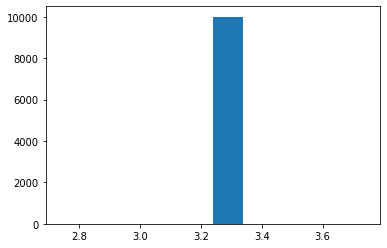

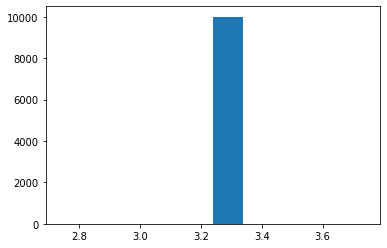

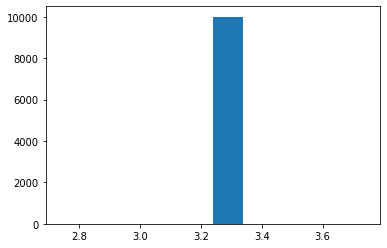

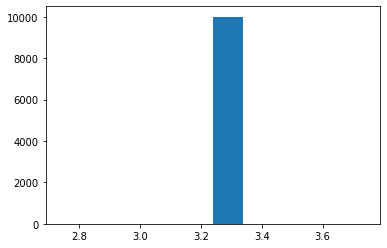

In [10]:
for label in range(4):
    model1_distribution = pd.DataFrame(columns=['label','x','h1'])
    for G in Dataset_without_perturb[label]:
        output1, h1 = model1(dgl.from_networkx(G), torch.ones((nodes_num,1)))
        #print([label]+(np.array(output1.detach().numpy()).tolist()[0]))
        #print(pd.DataFrame([[label]+(np.array(output1.detach().numpy()).tolist()[0])],columns = ['label', 'x', 'h1'] ))
        model1_distribution = model1_distribution.append(pd.DataFrame([[label]+(np.array(output1.detach().numpy()).tolist()[0])],columns = ['label', 'x', 'h1'] ))
    plt.hist(model1_distribution['h1'])
    plt.show()

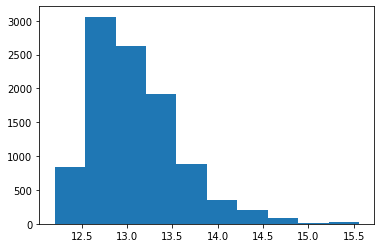

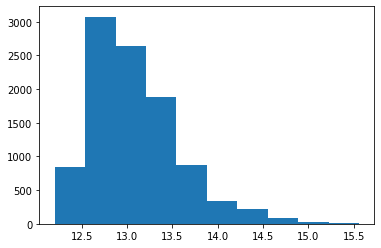

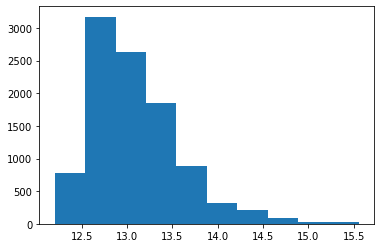

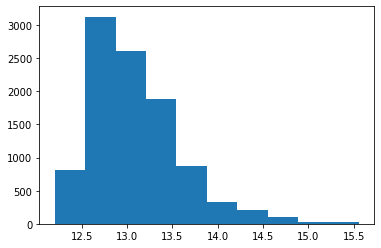

In [11]:
for label in range(4):
    model1_distribution = pd.DataFrame(columns=['label','x','h1','h2'])
    for G in Dataset_with_perturb[label]:
        output1, h1 = model2(dgl.from_networkx(G), torch.ones((nodes_num,1)))
        #print([label]+(np.array(output1.detach().numpy()).tolist()[0]))
        #print(pd.DataFrame([[label]+(np.array(output1.detach().numpy()).tolist()[0])],columns = ['label', 'x', 'h1'] ))
        model1_distribution = model1_distribution.append(pd.DataFrame([[label]+(np.array(output1.detach().numpy()).tolist()[0])],columns = ['label', 'x', 'h1', 'h2'] ))
    plt.hist(model1_distribution['h2'])
    plt.show()

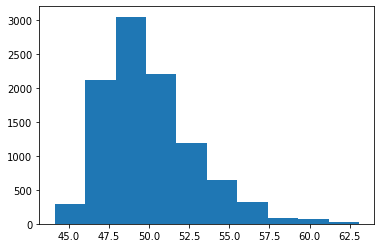

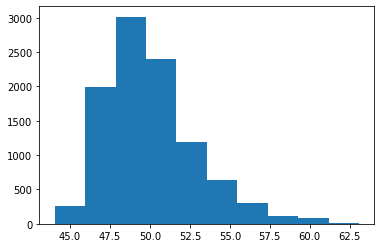

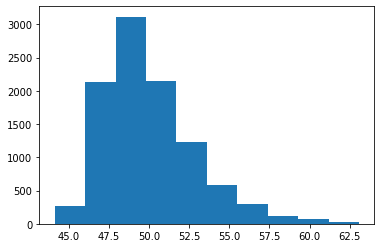

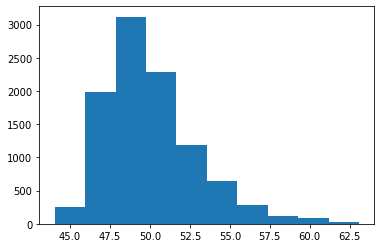

In [12]:
for label in range(4):
    model1_distribution = pd.DataFrame(columns=['label','x','h1','h2','h3'])
    for G in Dataset_with_perturb[label]:
        output1, h1 = model3(dgl.from_networkx(G), torch.ones((nodes_num,1)))
        #print([label]+(np.array(output1.detach().numpy()).tolist()[0]))
        #print(pd.DataFrame([[label]+(np.array(output1.detach().numpy()).tolist()[0])],columns = ['label', 'x', 'h1'] ))
        model1_distribution = model1_distribution.append(pd.DataFrame([[label]+(np.array(output1.detach().numpy()).tolist()[0])],columns = ['label', 'x', 'h1', 'h2', 'h3'] ))
    plt.hist(model1_distribution['h3'])
    plt.show()

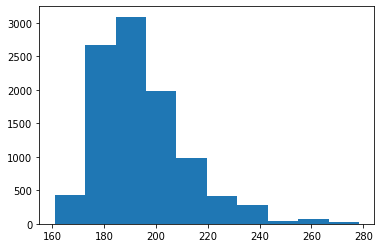

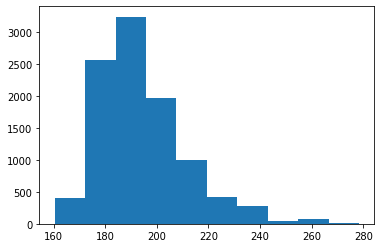

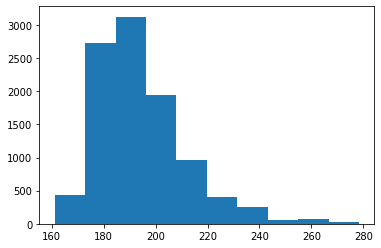

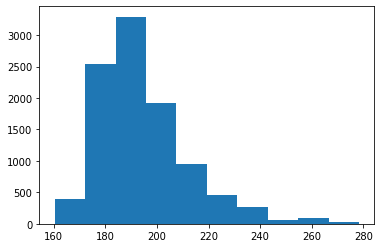

In [13]:
for label in range(4):
    model1_distribution = pd.DataFrame(columns=['label','x','h1','h2','h3', 'h4'])
    for G in Dataset_with_perturb[label]:
        output1, h1 = model4(dgl.from_networkx(G), torch.ones((nodes_num,1)))
        #print([label]+(np.array(output1.detach().numpy()).tolist()[0]))
        #print(pd.DataFrame([[label]+(np.array(output1.detach().numpy()).tolist()[0])],columns = ['label', 'x', 'h1'] ))
        model1_distribution = model1_distribution.append(pd.DataFrame([[label]+(np.array(output1.detach().numpy()).tolist()[0])],columns = ['label', 'x', 'h1', 'h2', 'h3', 'h4'] ))
    plt.hist(model1_distribution['h4'])
    plt.show()

# M = 5

In [14]:
Dataset_with_perturb = defaultdict(list)
Dataset_without_perturb = defaultdict(list)
for label in range(4):
    for _ in range(10000):
        Dataset_with_perturb[label].append(generate_single_sample(3, 4, nodes_num, m = 5, perturb_dic = {4:'square_diagonal'}))
        Dataset_without_perturb[label].append(generate_single_sample(3, 0, nodes_num, m = 5))

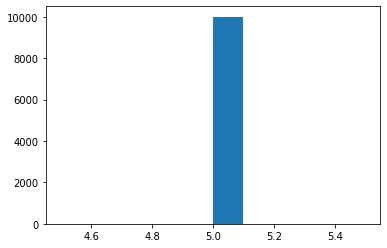

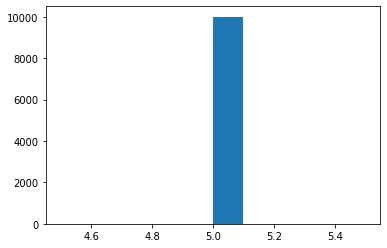

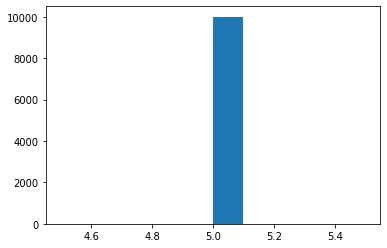

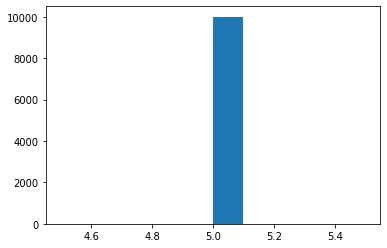

In [15]:
for label in range(4):
    model1_distribution = pd.DataFrame(columns=['label','x','h1','h2','h3', 'h4'])
    for G in Dataset_with_perturb[label]:
        output1, h1 = model4(dgl.from_networkx(G), torch.ones((nodes_num,1)))
        #print([label]+(np.array(output1.detach().numpy()).tolist()[0]))
        #print(pd.DataFrame([[label]+(np.array(output1.detach().numpy()).tolist()[0])],columns = ['label', 'x', 'h1'] ))
        model1_distribution = model1_distribution.append(pd.DataFrame([[label]+(np.array(output1.detach().numpy()).tolist()[0])],columns = ['label', 'x', 'h1', 'h2', 'h3', 'h4'] ))
    plt.hist(model1_distribution['h1'])
    plt.show()

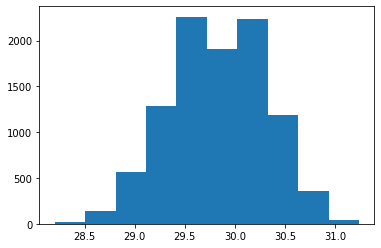

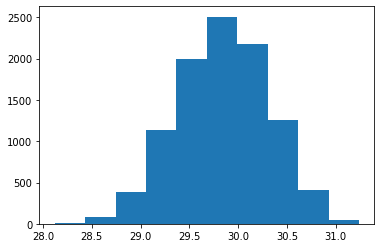

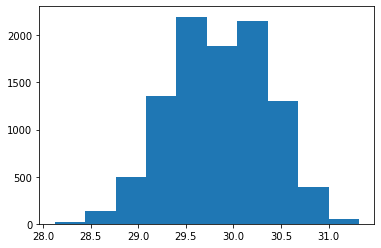

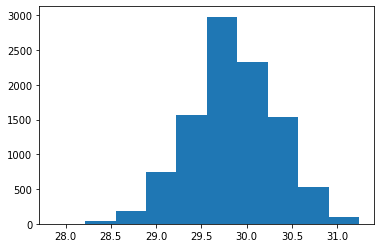

In [16]:
for label in range(4):
    model1_distribution = pd.DataFrame(columns=['label','x','h1','h2','h3', 'h4'])
    for G in Dataset_with_perturb[label]:
        output1, h1 = model4(dgl.from_networkx(G), torch.ones((nodes_num,1)))
        #print([label]+(np.array(output1.detach().numpy()).tolist()[0]))
        #print(pd.DataFrame([[label]+(np.array(output1.detach().numpy()).tolist()[0])],columns = ['label', 'x', 'h1'] ))
        model1_distribution = model1_distribution.append(pd.DataFrame([[label]+(np.array(output1.detach().numpy()).tolist()[0])],columns = ['label', 'x', 'h1', 'h2', 'h3', 'h4'] ))
    plt.hist(model1_distribution['h2'])
    plt.show()

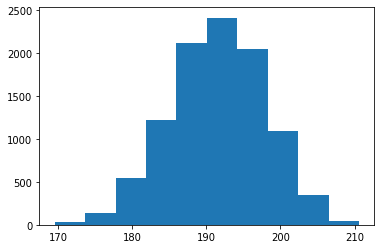

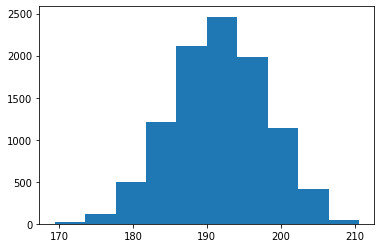

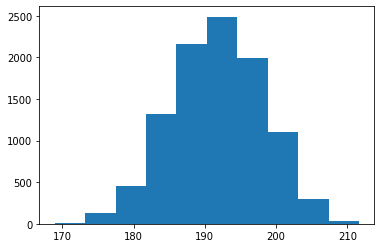

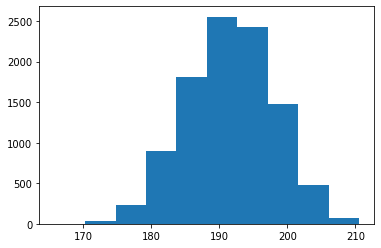

In [17]:
for label in range(4):
    model1_distribution = pd.DataFrame(columns=['label','x','h1','h2','h3', 'h4'])
    for G in Dataset_with_perturb[label]:
        output1, h1 = model4(dgl.from_networkx(G), torch.ones((nodes_num,1)))
        #print([label]+(np.array(output1.detach().numpy()).tolist()[0]))
        #print(pd.DataFrame([[label]+(np.array(output1.detach().numpy()).tolist()[0])],columns = ['label', 'x', 'h1'] ))
        model1_distribution = model1_distribution.append(pd.DataFrame([[label]+(np.array(output1.detach().numpy()).tolist()[0])],columns = ['label', 'x', 'h1', 'h2', 'h3', 'h4'] ))
    plt.hist(model1_distribution['h3'])
    plt.show()

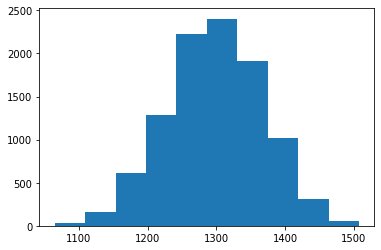

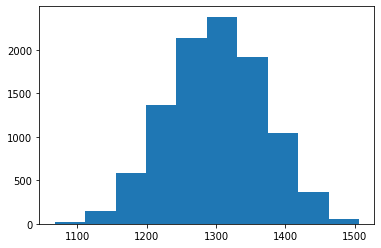

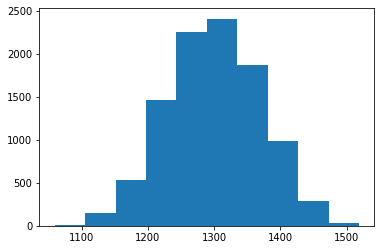

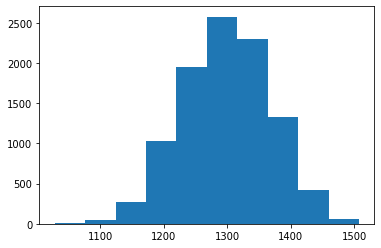

In [18]:
for label in range(4):
    model1_distribution = pd.DataFrame(columns=['label','x','h1','h2','h3', 'h4'])
    for G in Dataset_with_perturb[label]:
        output1, h1 = model4(dgl.from_networkx(G), torch.ones((nodes_num,1)))
        #print([label]+(np.array(output1.detach().numpy()).tolist()[0]))
        #print(pd.DataFrame([[label]+(np.array(output1.detach().numpy()).tolist()[0])],columns = ['label', 'x', 'h1'] ))
        model1_distribution = model1_distribution.append(pd.DataFrame([[label]+(np.array(output1.detach().numpy()).tolist()[0])],columns = ['label', 'x', 'h1', 'h2', 'h3', 'h4'] ))
    plt.hist(model1_distribution['h4'])
    plt.show()

# 定义一层的神经网络训练后看效果

In [11]:
from tqdm import tqdm as tq
from dgl.nn import GraphConv
class GraphConvWL(nn.Module):
    r'''
    Description
    -----------
    Similar to GraphConv in PyG

    This graph convolution operater was introduced in `"Weisfeiler and Leman Go
    Neural: Higher-order Graph Neural Networks"
    <https://arxiv.org/abs/1810.02244>`_ paper

    Parameters
    ----------
    in_feats : int
        Input feature size; i.e, the number of dimensions of :math:`h_j^{(l)}`.
    out_feats : int
        Output feature size; i.e., the number of dimensions of :math:`h_i^{(l+1)}`.
    bias : bool, optional
        If True, apply a learnable bias to the output. Default: ``True``
    allow_zero_in_degree : bool, optional
        If there are 0-in-degree nodes in the graph, output for those nodes will be invalid
        since no message will be passed to those nodes. This is harmful for some applications
        causing silent performance regression. This module will raise a DGLError if it detects
        0-in-degree nodes in input graph. By setting ``True``, it will suppress the check
        and let the users handle it by themselves. Default: ``True``.
    '''
    def __init__(self,
                in_feats,
                out_feats,
                bias = True,
                allow_zero_in_degree = True) -> None:
        super().__init__()
        self.conv_from_neigh = GraphConv(in_feats, out_feats, norm = 'none', weight = True, bias = bias, allow_zero_in_degree = allow_zero_in_degree)
        self.conv_from_self = nn.Linear(in_feats,out_feats, bias = False)

        self.reset_parameters()
    
    def reset_parameters(self):
        self.conv_from_neigh.reset_parameters()
        self.conv_from_self.reset_parameters()

    def forward(self, graph, feat):
        neigh_feat = self.conv_from_neigh(graph, feat)
        self_feat = self.conv_from_self(feat)
        return neigh_feat+self_feat


class Net3(torch.nn.Module):
    def __init__(self, num_node_features, num_classes, num_layers, concat_features, conv_type, dim = 1, report = False, readout = 'Mean'):
        super(Net3, self).__init__()
        dim = dim
        self.report = report
        self.readout = readout
        self.convs = torch.nn.ModuleList()
        if conv_type == 'GraphConvWL':#'GCNConv':
            conv_class = GraphConvWL
            #kwargs = {'add_self_loops': False}
        elif conv_type == 'GraphConv':
            conv_class = GraphConv
            kwargs = {}
        else:
            raise RuntimeError(f"conv_type {conv_type} not supported")

        self.convs.append(conv_class(num_node_features, dim))#, **kwargs))
        for i in range(num_layers - 1):
            self.convs.append(conv_class(dim, dim))#, **kwargs))
        self.concat_features = concat_features
        if concat_features:
            self.fc = Linear(dim * num_layers + num_node_features, num_classes)
        else:
            self.fc = Linear(dim, num_classes)

    def forward(self, g, x):
        '''
        g: DGL Graph
        x: node feature
        '''
        xs = [x]
        for conv in self.convs:
            x = conv(g, x)
            if self.report:
                print(x)
            x = F.relu(x)
            xs.append(x)
        if self.concat_features:
            x = torch.cat(xs, dim=1)
        g.ndata['h'] = x
        if self.readout == 'Mean':
            hg = dgl.mean_nodes(g, 'h')
        elif self.readout == 'Max':
            hg = dgl.max_nodes(g, 'h')
        if self.report:
            print(hg)
        hg = self.fc(hg)
        return F.log_softmax(hg, dim=1)
def model_train_with_dim(layers, dim, epochs_num = 150, m = 5, readout = 'Mean', graph_num = 1000):
    
    EPOCHS_NUM = epochs_num
    m = m
    device = torch.device('cuda')
    data = BA4labelDataset(graph_num = graph_num, m = m,nodes_num=25, perturb_dic = {4:'square_diagonal'})
    dataloader = dgl.dataloading.GraphDataLoader(data, batch_size = 16, shuffle = True)
    data = BA4labelDataset(graph_num = graph_num, m = m,nodes_num=25, perturb_dic = {4:'square_diagonal'})
    testdataloader = dgl.dataloading.GraphDataLoader(data, batch_size = 16, shuffle = True)
    model = Net3(data.num_node_features, data.num_classes, layers, True,
                                        'GraphConvWL', dim = dim, readout = readout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=0)

    model.train()
    pbar = tq(range(EPOCHS_NUM))
    for epoch in pbar:
        #train
        loss_all = 0
        for g, labels in dataloader:
            g = g.to(device)
            optimizer.zero_grad()
            output = model(g, g.ndata['x'])
            loss = F.nll_loss(output, labels.to(device))
            loss.backward()
            loss_all += loss.item()
            optimizer.step()
        train_loss = loss_all/len(dataloader)
        #train_acc
        model.eval()

        correct = 0
        total = 0
        for g, labels in dataloader:
            g = g.to(device)
            output = model(g, g.ndata['x'])
            pred = output.max(dim=1)[1]
            eq_pred = pred.eq(labels.to(device))
            correct += eq_pred.sum().item()
            total += len(labels.to(device))
        train_acc = correct/total
        #test_acc
        model.eval()

        correct = 0
        total = 0
        for g, labels in testdataloader:
            g = g.to(device)
            output = model(g, g.ndata['x'])
            pred = output.max(dim=1)[1]
            eq_pred = pred.eq(labels.to(device))
            correct += eq_pred.sum().item()
            total += len(labels.to(device))
        test_acc = correct/total

        pbar.set_postfix(train_loss=train_loss, train_acc = train_acc, test_acc = test_acc)
    return model, train_acc,test_acc

In [20]:
for _ in range(10):
    model_train_with_dim(3,3)#改成跑很多次取其中最好的一次

100%|██████████| 150/150 [01:36<00:00,  1.55it/s, test_acc=0.252, train_acc=0.264, train_loss=1.39]


In [29]:
model, train_acc, test_acc = model_train_with_dim(3,4,300)

100%|██████████| 300/300 [03:11<00:00,  1.57it/s, test_acc=1, train_acc=1, train_loss=0.0429]        


In [31]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0286,  0.6189,  1.1242, -0.5253]], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([ 0.9922,  0.2922,  1.2136, -0.0056], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([[1.7798],
         [1.0855],
         [0.3736],
         [0.5239]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[ 0.1403, -0.8412,  1.2419, -0.0431],
         [ 1.2534, -0.1181, -0.6804, -0.1899],
         [ 0.7765, -0.1002,  0.5927,  0.0268],
         [ 0.0070, -0.1661,  0.7896, -0.1006]], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([-1.1772,  0.0000,  1.5799,  0.0000], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([[-0.8573, -0.0726, -0.3774, -0.3553],
         [ 0.1620, -0.3559,  0.4843,  0.1948],
         [ 2.1382,  1.4711,  0.2640,  0.1428],
         [ 0.3973, -0.2096, -0.0965, -0.0336]], device='cuda:0',
        requires_grad=True),

In [51]:
model.state_dict()

OrderedDict([('convs.0.conv_from_neigh.weight',
              tensor([[-0.0286,  0.6189,  1.1242, -0.5253]], device='cuda:0')),
             ('convs.0.conv_from_neigh.bias',
              tensor([ 0.9922,  0.2922,  1.2136, -0.0056], device='cuda:0')),
             ('convs.0.conv_from_self.weight',
              tensor([[1.7798],
                      [1.0855],
                      [0.3736],
                      [0.5239]], device='cuda:0')),
             ('convs.1.conv_from_neigh.weight',
              tensor([[ 0.1403, -0.8412,  1.2419, -0.0431],
                      [ 1.2534, -0.1181, -0.6804, -0.1899],
                      [ 0.7765, -0.1002,  0.5927,  0.0268],
                      [ 0.0070, -0.1661,  0.7896, -0.1006]], device='cuda:0')),
             ('convs.1.conv_from_neigh.bias',
              tensor([-1.1772,  0.0000,  1.5799,  0.0000], device='cuda:0')),
             ('convs.1.conv_from_self.weight',
              tensor([[-0.8573, -0.0726, -0.3774, -0.3553],
              

<All keys matched successfully>

In [60]:
model2, train_acc2, test_acc2 = model_train_with_dim(3, 8, 1000, m = 1)

100%|██████████| 1000/1000 [10:53<00:00,  1.53it/s, test_acc=0.982, train_acc=0.991, train_loss=0.0464]


In [61]:
model3, train_acc3, test_acc3 = model_train_with_dim(3, 8, 2000, m = 1)

100%|██████████| 2000/2000 [21:58<00:00,  1.52it/s, test_acc=0.998, train_acc=1, train_loss=0.00343]    


# 用一个样本来观察模型的识别过程

tensor([[ 2.6578,  3.8532,  6.0840, -1.5827],
        [ 2.7149,  2.6155,  3.8356, -0.5322],
        [ 2.6578,  3.8532,  6.0840, -1.5827],
        [ 2.7149,  2.6155,  3.8356, -0.5322],
        [ 2.7149,  2.6155,  3.8356, -0.5322],
        [ 2.7149,  2.6155,  3.8356, -0.5322],
        [ 2.7149,  2.6155,  3.8356, -0.5322],
        [ 2.7434,  1.9966,  2.7114, -0.0069],
        [ 2.7149,  2.6155,  3.8356, -0.5322],
        [ 2.7434,  1.9966,  2.7114, -0.0069],
        [ 2.7434,  1.9966,  2.7114, -0.0069],
        [ 2.6578,  3.8532,  6.0840, -1.5827],
        [ 2.6863,  3.2343,  4.9598, -1.0575],
        [ 2.7149,  2.6155,  3.8356, -0.5322],
        [ 2.7149,  2.6155,  3.8356, -0.5322],
        [ 2.7149,  2.6155,  3.8356, -0.5322],
        [ 2.6578,  3.8532,  6.0840, -1.5827],
        [ 2.6863,  3.2343,  4.9598, -1.0575],
        [ 2.7149,  2.6155,  3.8356, -0.5322],
        [ 2.7149,  2.6155,  3.8356, -0.5322],
        [ 2.7149,  2.6155,  3.8356, -0.5322],
        [ 2.6578,  3.8532,  6.0840

tensor([1], device='cuda:0')

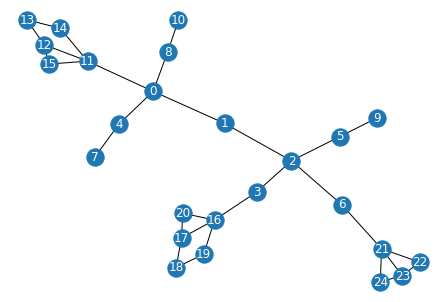

In [83]:
device = torch.device('cuda')
model_test = Net3(1, 4, 3, True,'GraphConvWL', dim = 4,report = True)
model_test.load_state_dict(model.state_dict())
model_test = model_test.to(device)
G = generate_single_sample(3, 4, nodes_num = 25, m = 1, perturb_dic = {4:'square_diagonal'}, seed = 0)
pos = nx.spring_layout(G, seed = 0)
nx.draw(G, pos, with_labels = True, font_color = 'white')
g = dgl.from_networkx(G)
g = g.to(device)
output = model_test(g, torch.ones((25,1)).to(device))
print(output)
output.max(dim = 1)[1]

In [7]:
def test_model_with_another_m(model_test, m):
    model_test.eval()
    data = BA4labelDataset(m = m, nodes_num=25, perturb_dic = {4:'square_diagonal'})
    testdataloader = dgl.dataloading.GraphDataLoader(data, batch_size = 16, shuffle = True)
    correct = 0
    total = 0
    for g, labels in testdataloader:
        g = g.to(device)
        output = model_test(g, g.ndata['x'])
        pred = output.max(dim=1)[1]
        eq_pred = pred.eq(labels.to(device))
        correct += eq_pred.sum().item()
        total += len(labels.to(device))
    test_acc = correct/total
    return test_acc

In [84]:
test_model_with_another_m(model_test, 1)

tensor([[ 2.6863,  3.2343,  4.9598, -1.0575],
        [ 2.5721,  5.7098,  9.4567, -3.1586],
        [ 2.6863,  3.2343,  4.9598, -1.0575],
        ...,
        [ 2.7149,  2.6155,  3.8356, -0.5322],
        [ 2.6863,  3.2343,  4.9598, -1.0575],
        [ 2.7149,  2.6155,  3.8356, -0.5322]], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[ 30.7711,  -8.8615,  27.0847,  -2.4846],
        [ 39.0959, -17.8736,  45.0330,  -4.6655],
        [ 20.9036,  -7.8913,  25.8262,  -1.9675],
        ...,
        [ 13.0664,  -5.0723,  20.6050,  -1.1206],
        [ 17.6145,  -7.5679,  25.4067,  -1.7951],
        [ 13.0664,  -5.0723,  20.6050,  -1.1206]], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[ 59.3513, -33.0518,  19.8086,  59.2485],
        [ 82.0190, -37.6805,  30.2134,  82.5965],
        [ 48.8428,   4.2462,   8.4046,  45.2716],
        ...,
        [ 33.8977,  -1.0402,   9.3289,  32.2013],
        [ 43.6675,   1.6972,  10.0102,  41.1013],
        [ 33.8977,  -1.0402,   9.3289

0.333

In [85]:
model_test = Net3(1, 4, 3, True,'GraphConvWL', dim = 8,report = True)
model_test.load_state_dict(model3.state_dict())
model_test = model_test.to(device)
test_model_with_another_m(model_test, 1)
#发现准确率接近1的模型在调整基础随机图的m后，无法应用到其他模型上，这时我们需要确定这是不是偶然导致，以及是不是由于我们降低了变量维度导致的

tensor([[ 3.1400,  8.7974,  4.1902,  ...,  4.3496,  3.6335, -6.9473],
        [ 2.6374,  0.7604, -0.7019,  ..., -0.7396,  0.8025, -1.6479],
        [ 2.7810,  3.0567,  0.6958,  ...,  0.7145,  1.6114, -3.1620],
        ...,
        [ 2.6374,  0.7604, -0.7019,  ..., -0.7396,  0.8025, -1.6479],
        [ 2.6374,  0.7604, -0.7019,  ..., -0.7396,  0.8025, -1.6479],
        [ 2.6374,  0.7604, -0.7019,  ..., -0.7396,  0.8025, -1.6479]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor([[ -6.4090,  24.1385, -16.6618,  ...,  28.2434,  54.4529,  38.0178],
        [ -1.9498,  11.7934,  -5.9322,  ...,   5.5346,  23.4736,   0.5009],
        [ -3.2354,  15.3981,  -9.4164,  ...,  12.7323,  28.9261,   9.0351],
        ...,
        [ -1.7512,   4.8398,  -3.1583,  ...,   1.2221,   2.7353,  -1.3875],
        [ -1.7109,   3.4677,  -2.6124,  ...,   0.3463,  -1.3875,  -1.7527],
        [ -1.7109,   3.4677,  -2.6124,  ...,   0.3463,  -1.3875,  -1.7527]],
       device='cuda:0', grad_fn=<AddBackward0>)


0.998

# 检查模型在m不同时的平均表现

In [86]:
result = []
for _ in range(10):
    model_5, train_acc_5, test_acc_5 = model_train_with_dim(3,32,150, m = 5)
    temp = test_model_with_another_m(model_5, 1)
    print('Acc on dataset m = 1', temp)
    result.append([train_acc_5, test_acc_5,temp])
print(result, np.mean(result, axis = 0))

100%|██████████| 150/150 [01:40<00:00,  1.49it/s, test_acc=1, train_acc=1, train_loss=0.0011]      


Acc on dataset m = 1 0.264


100%|██████████| 150/150 [01:40<00:00,  1.49it/s, test_acc=1, train_acc=1, train_loss=0.00182]      


Acc on dataset m = 1 0.282


100%|██████████| 150/150 [01:39<00:00,  1.50it/s, test_acc=0.997, train_acc=0.997, train_loss=0.145]


Acc on dataset m = 1 0.269


100%|██████████| 150/150 [01:39<00:00,  1.51it/s, test_acc=1, train_acc=1, train_loss=0.00118]     


Acc on dataset m = 1 0.272


100%|██████████| 150/150 [01:39<00:00,  1.51it/s, test_acc=1, train_acc=1, train_loss=0.000744]     


Acc on dataset m = 1 0.235


100%|██████████| 150/150 [01:39<00:00,  1.51it/s, test_acc=1, train_acc=1, train_loss=0.00047]     


Acc on dataset m = 1 0.66


100%|██████████| 150/150 [01:39<00:00,  1.51it/s, test_acc=1, train_acc=1, train_loss=0.000697]    


Acc on dataset m = 1 0.274


100%|██████████| 150/150 [01:39<00:00,  1.51it/s, test_acc=1, train_acc=1, train_loss=0.00676]      


Acc on dataset m = 1 0.263


100%|██████████| 150/150 [01:39<00:00,  1.51it/s, test_acc=1, train_acc=1, train_loss=0.00181]     


Acc on dataset m = 1 0.498


100%|██████████| 150/150 [01:39<00:00,  1.51it/s, test_acc=1, train_acc=1, train_loss=0.00258]      


Acc on dataset m = 1 0.254
[[1.0, 1.0, 0.264], [1.0, 1.0, 0.282], [0.997, 0.997, 0.269], [1.0, 1.0, 0.272], [1.0, 1.0, 0.235], [1.0, 1.0, 0.66], [1.0, 1.0, 0.274], [1.0, 1.0, 0.263], [1.0, 1.0, 0.498], [1.0, 1.0, 0.254]] [0.9997 0.9997 0.3271]


In [87]:
result = []
for _ in range(10):
    model_5, train_acc_5, test_acc_5 = model_train_with_dim(3,32,300, m = 1)
    temp = test_model_with_another_m(model_5, 5)
    print('Acc on dataset m = 5', temp)
    result.append([train_acc_5, test_acc_5,temp])
print(result, np.mean(result, axis = 0))

100%|██████████| 300/300 [03:18<00:00,  1.51it/s, test_acc=0.997, train_acc=1, train_loss=0.005]      


Acc on dataset m = 5 0.255


100%|██████████| 300/300 [03:18<00:00,  1.51it/s, test_acc=0.994, train_acc=0.995, train_loss=0.0222]


Acc on dataset m = 5 0.255


100%|██████████| 300/300 [03:18<00:00,  1.51it/s, test_acc=0.997, train_acc=0.998, train_loss=0.0191]


Acc on dataset m = 5 0.245


100%|██████████| 300/300 [03:19<00:00,  1.50it/s, test_acc=0.997, train_acc=0.999, train_loss=0.00806]


Acc on dataset m = 5 0.492


100%|██████████| 300/300 [03:19<00:00,  1.50it/s, test_acc=0.997, train_acc=0.997, train_loss=0.0329]


Acc on dataset m = 5 0.25


100%|██████████| 300/300 [03:19<00:00,  1.50it/s, test_acc=0.998, train_acc=1, train_loss=0.0032]     


Acc on dataset m = 5 0.249


100%|██████████| 300/300 [03:19<00:00,  1.50it/s, test_acc=0.999, train_acc=0.997, train_loss=0.0214]


Acc on dataset m = 5 0.272


100%|██████████| 300/300 [03:13<00:00,  1.55it/s, test_acc=0.998, train_acc=0.998, train_loss=0.0111]


Acc on dataset m = 5 0.219


100%|██████████| 300/300 [03:12<00:00,  1.56it/s, test_acc=0.999, train_acc=0.997, train_loss=0.0177]


Acc on dataset m = 5 0.24


100%|██████████| 300/300 [03:13<00:00,  1.55it/s, test_acc=0.999, train_acc=0.999, train_loss=0.00711]


Acc on dataset m = 5 0.249
[[1.0, 0.997, 0.255], [0.995, 0.994, 0.255], [0.998, 0.997, 0.245], [0.999, 0.997, 0.492], [0.997, 0.997, 0.25], [1.0, 0.998, 0.249], [0.997, 0.999, 0.272], [0.998, 0.998, 0.219], [0.997, 0.999, 0.24], [0.999, 0.999, 0.249]] [0.998  0.9975 0.2726]


# 改变模型readout层

In [9]:
device = torch.device('cuda')
result = []
for _ in range(10):
    model_5, train_acc_5, test_acc_5 = model_train_with_dim(3,32,150, m = 5, readout = 'Max')
    temp = test_model_with_another_m(model_5, 1)
    print('Acc on dataset m = 1', temp)
    result.append([train_acc_5, test_acc_5,temp])
print(result, np.mean(result, axis = 0))

100%|██████████| 150/150 [01:49<00:00,  1.37it/s, test_acc=1, train_acc=0.999, train_loss=0.0109]     


Acc on dataset m = 1 0.256


100%|██████████| 150/150 [01:49<00:00,  1.37it/s, test_acc=0.995, train_acc=0.996, train_loss=0.0177]


Acc on dataset m = 1 0.317


100%|██████████| 150/150 [01:49<00:00,  1.36it/s, test_acc=0.987, train_acc=0.987, train_loss=0.0589]


Acc on dataset m = 1 0.322


100%|██████████| 150/150 [01:49<00:00,  1.36it/s, test_acc=0.995, train_acc=0.995, train_loss=0.0387]


Acc on dataset m = 1 0.243


100%|██████████| 150/150 [01:50<00:00,  1.36it/s, test_acc=1, train_acc=1, train_loss=0.000294]     


Acc on dataset m = 1 0.264


100%|██████████| 150/150 [01:40<00:00,  1.49it/s, test_acc=0.998, train_acc=0.997, train_loss=0.0119] 


Acc on dataset m = 1 0.377


100%|██████████| 150/150 [01:37<00:00,  1.54it/s, test_acc=1, train_acc=1, train_loss=0.000213]     


Acc on dataset m = 1 0.267


100%|██████████| 150/150 [01:36<00:00,  1.55it/s, test_acc=0.999, train_acc=1, train_loss=0.00139]    


Acc on dataset m = 1 0.371


100%|██████████| 150/150 [01:36<00:00,  1.55it/s, test_acc=1, train_acc=1, train_loss=0.00797]        


Acc on dataset m = 1 0.338


100%|██████████| 150/150 [01:36<00:00,  1.55it/s, test_acc=1, train_acc=1, train_loss=0.00409]       


Acc on dataset m = 1 0.325
[[0.999, 1.0, 0.256], [0.996, 0.995, 0.317], [0.987, 0.987, 0.322], [0.995, 0.995, 0.243], [1.0, 1.0, 0.264], [0.997, 0.998, 0.377], [1.0, 1.0, 0.267], [1.0, 0.999, 0.371], [1.0, 1.0, 0.338], [1.0, 1.0, 0.325]] [0.9974 0.9974 0.308 ]


In [10]:
result = []
for _ in range(10):
    model_5, train_acc_5, test_acc_5 = model_train_with_dim(3,32,300, m = 1, readout = 'Max')
    temp = test_model_with_another_m(model_5, 5)
    print('Acc on dataset m = 5', temp)
    result.append([train_acc_5, test_acc_5,temp])
print(result, np.mean(result, axis = 0))

100%|██████████| 300/300 [03:13<00:00,  1.55it/s, test_acc=0.961, train_acc=0.978, train_loss=0.0591]


Acc on dataset m = 5 0.252


100%|██████████| 300/300 [03:11<00:00,  1.57it/s, test_acc=0.955, train_acc=0.978, train_loss=0.0608]


Acc on dataset m = 5 0.257


100%|██████████| 300/300 [03:11<00:00,  1.56it/s, test_acc=0.937, train_acc=0.967, train_loss=0.108]


Acc on dataset m = 5 0.258


100%|██████████| 300/300 [03:13<00:00,  1.55it/s, test_acc=0.928, train_acc=0.968, train_loss=0.0985]


Acc on dataset m = 5 0.283


100%|██████████| 300/300 [03:14<00:00,  1.54it/s, test_acc=0.957, train_acc=0.98, train_loss=0.0783] 


Acc on dataset m = 5 0.261


100%|██████████| 300/300 [03:16<00:00,  1.53it/s, test_acc=0.93, train_acc=0.947, train_loss=0.112] 


Acc on dataset m = 5 0.23


100%|██████████| 300/300 [03:19<00:00,  1.50it/s, test_acc=0.901, train_acc=0.933, train_loss=0.124] 


Acc on dataset m = 5 0.342


100%|██████████| 300/300 [03:37<00:00,  1.38it/s, test_acc=0.947, train_acc=0.959, train_loss=0.108]


Acc on dataset m = 5 0.292


100%|██████████| 300/300 [03:21<00:00,  1.49it/s, test_acc=0.952, train_acc=0.98, train_loss=0.0708] 


Acc on dataset m = 5 0.239


100%|██████████| 300/300 [03:15<00:00,  1.54it/s, test_acc=0.988, train_acc=0.995, train_loss=0.0307]


Acc on dataset m = 5 0.554
[[0.978, 0.961, 0.252], [0.978, 0.955, 0.257], [0.967, 0.937, 0.258], [0.968, 0.928, 0.283], [0.98, 0.957, 0.261], [0.947, 0.93, 0.23], [0.933, 0.901, 0.342], [0.959, 0.947, 0.292], [0.98, 0.952, 0.239], [0.995, 0.988, 0.554]] [0.9685 0.9456 0.2968]
